# Train deepRetina

In [1]:
# A bit of setup
import numpy as np
from scipy.io import loadmat
import os.path as path
import matplotlib.pyplot as plt
from nems.utilities import rolling_window
from lnl_model_functions import *
from matplotlib.pyplot import *
from pyret.filtertools import getsta, filterpeak # input: (time,), stim (x,x,x,time), spikes (times,)
import pyret.visualizations as viz # note that this imports seaborn and messes up all plotting functions
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import mpld3

# from time import time
# import re
# from os import listdir
# from os.path import isfile, join
# from scipy import misc
# import scipy.io


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module IPython was already imported from /Users/lmcintosh/Git/ipython/IPython/__init__.pyc, but /Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


# Load data

#### Use float32 stim

In [3]:
data_dir = '/Users/lmcintosh/Git/deepRGC/datasets/white_noise/'
metadata = np.load(path.join(data_dir, 'metadata.npz'))['metadata'].item()
stim  = np.memmap(path.join(data_dir, 'stim_float.dat'), dtype=metadata['stim_float_dtype'], 
                  mode='r', shape=metadata['stim_float_shape'])
rates = np.memmap(path.join(data_dir, 'rates.dat'), dtype=metadata['rates_dtype'], 
                  mode='r', shape=metadata['rates_shape'])

### Smooth raw spike count with 10 ms std Gaussian to get PSTHs

In [8]:
rates_filt = np.zeros(rates.shape)
filt       = gaussian(x=np.linspace(-5,5,10), sigma=1, mu=0)
for cell in xrange(rates.shape[1]):
    rates_filt[:,cell] = np.convolve(rates[:,cell], filt, mode='same')

### Create 4d stim array where each data point is a 400ms (40 frame) movie

In [20]:
stim_sliced = stim[34:-34, 34:-34,:]

In [21]:
X = rolling_window(stim_sliced, 40)
X = np.rollaxis(X, 2)
X = np.rollaxis(X, 3, 1)

In [22]:
X.shape

(299850, 40, 32, 32)

In [23]:
X.T.shape

(32, 32, 40, 299850)

### Truncate rates to appropriate time frame

In [24]:
y = rates_filt[X.shape[1]:]

### Show STA as sanity check that data looks right

In [25]:
np.mean(y[:,0] > 0)

0.1414807403701851

In [80]:
times = np.linspace(0,0.01*len(rates),len(rates))
X_sta = {}
for cell in xrange(3): #xrange(rt.shape[1]):
    sptimes = times[rt[:,cell] > 0]
    X_sta[cell] = getsta(times, st, sptimes, 40)
    print cell

0
1
2


In [81]:
cell = 2

In [82]:
peak = filterpeak(X_sta[cell][0])

In [83]:
peak

((41, 63, 32), array([63, 41]), 32)

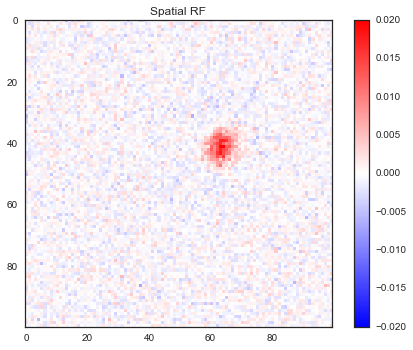

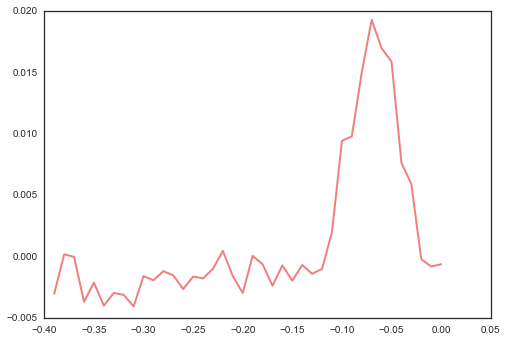

In [94]:
# also viz.playsta
viz.spatial(X_sta[cell][0][:,:,32])
viz.temporal(X_sta[cell][1], X_sta[cell][0][41,63,:])

In [9]:
X.shape

(299850, 40, 100, 100)

In [11]:
y.shape

(299850, 11)

## STA on filtered rates

In [26]:
def sta(stimulus, spiketrain):
    if len(spiketrain.shape) > 1:
        sta = {}
        for cell in xrange(spiketrain.shape[1]):
            sta[cell] = np.zeros(stimulus[0].shape)
            for spi, sp in enumerate(spiketrain[:,cell]):
                if spi % 100000 == 0:
                        print spi
                        
                if sp == 0:
                    pass
                else:
                    sta[cell] += sp * stimulus[spi]
            sta[cell] /= len(spiketrain[:,cell] > 0)
            print cell
        return sta
            
    else:
        sta = np.zeros(stimulus[0].shape)
        for spi, sp in enumerate(spiketrain):
            if spi % 100000 == 0:
                    print spi

            if sp == 0:
                pass
            else:
                sta += sp * stimulus[spi]
        sta /= len(spiketrain > 0)
        return sta
        
#         numSpikes = len(spiketrain)
#         sta = np.dot(stimulus.T, spiketrain)
#         sta /= numSpikes
#         return sta.T    

In [27]:
X.shape

(299850, 40, 32, 32)

In [28]:
X_sta = sta(X, y[:,0])

0
100000
200000


In [29]:
tmp = X_sta.copy()

In [30]:
X_sta[0].shape

(32, 32)

<matplotlib.colorbar.Colorbar instance at 0x3df531bd8>

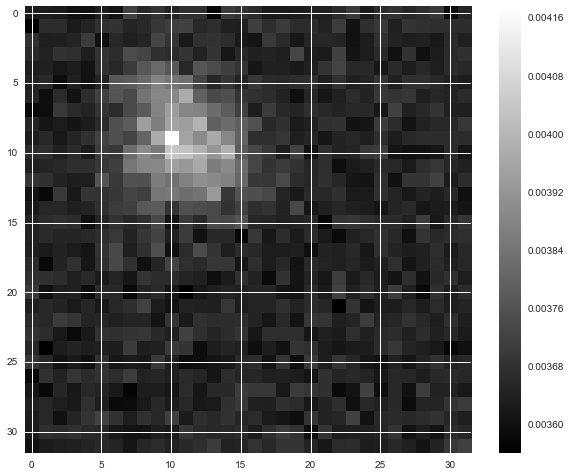

In [31]:
imshow(X_sta[30,:,:])
colorbar()

In [32]:
filterpeak(X_sta.T)

((10, 9, 32), array([ 9, 10]), 32)

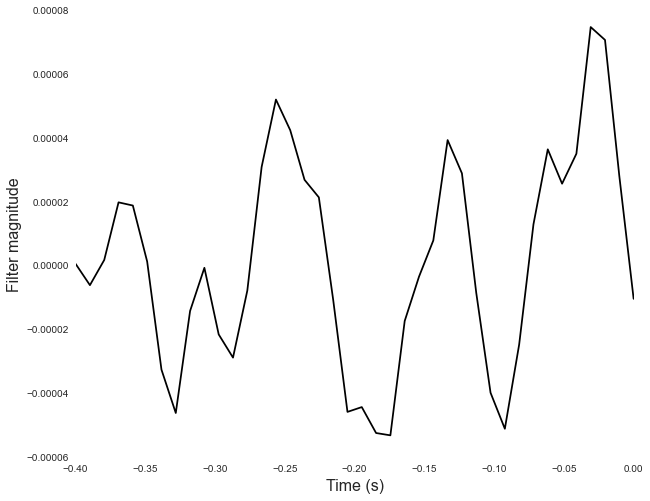

In [33]:
times = np.linspace(-0.01*X_sta.shape[0], 0, X_sta.shape[0])
plot(times, X_sta[:,18,19] - np.mean(X_sta[:20,:,:]), 'k')
xlim([np.min(times), 0])
xlabel('Time (s)', fontsize=16)
ylabel('Filter magnitude', fontsize=16)

In [13]:
cell = 0

In [45]:
subset = 1000
times = np.linspace(0, 0.01*len(y[:subset, cell]), len(y[:subset, cell]))
plot(times, y[:subset, cell], 'k')
xlabel('Time (s)', fontsize=16)
ylabel('Rates', fontsize=16)
mpld3.display()

# How well does an LN model predict spikes?

<matplotlib.colorbar.Colorbar instance at 0x1c90b6ea8>

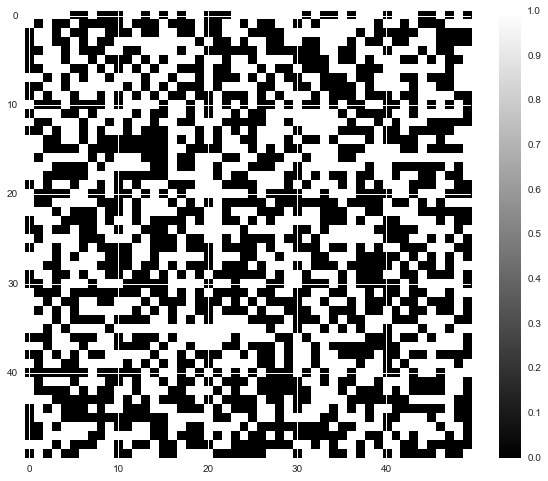

In [27]:
imshow(X[0,0,:,:])
colorbar()

In [57]:
subset = 10000
if subset:
    l_prediction = np.tensordot(X[:subset,:,:,:], X_sta - np.mean(X_sta[:20,:,:]), axes=3)
else:
    l_prediction = np.tensordot(X, X_sta - np.mean(X_sta[:20,:,:]), axes=3)

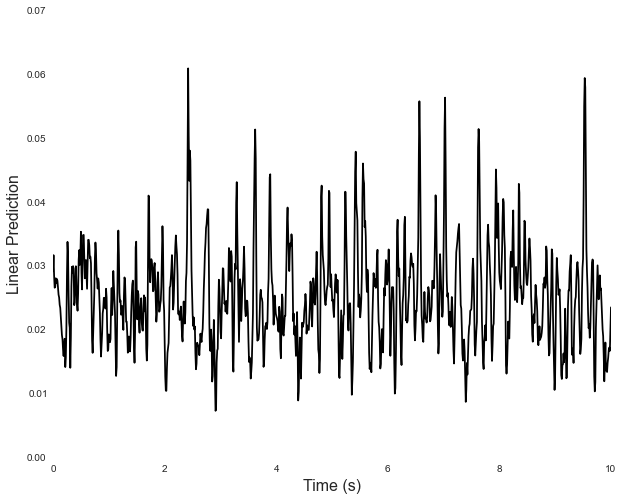

In [44]:
subset = 1000
times = np.linspace(0, 0.01*len(ln_prediction[:subset]), len(ln_prediction[:subset]))
plot(times, l_prediction[:subset],'k')
xlabel('Time (s)', fontsize=16)
ylabel('Linear Prediction', fontsize=16)

In [36]:
def logistic(x, a, b, c, d):
    return a/(1 + np.exp(-b*(x - c))) + d

In [26]:
subset = None
if subset:
    popt, pcov = curve_fit(logistic, l_prediction[:subset], y[:len(l_prediction[:subset]), 0])
else:
    popt, pcov = curve_fit(logistic, l_prediction, y[:len(l_prediction), 0])

NameError: name 'l_prediction' is not defined

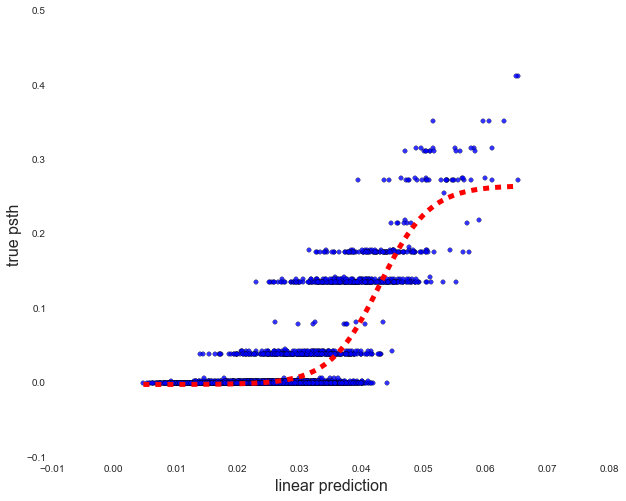

In [29]:
xs = np.linspace(np.min(l_prediction), np.max(l_prediction), 100)
scatter(l_prediction, y[:len(l_prediction),cell], alpha=0.8)
plot(xs, logistic(xs, *popt), 'r--', linewidth=5)
xlabel('linear prediction', fontsize=16)
ylabel('true psth', fontsize=16)

In [30]:
ln_prediction = logistic(l_prediction, *popt)

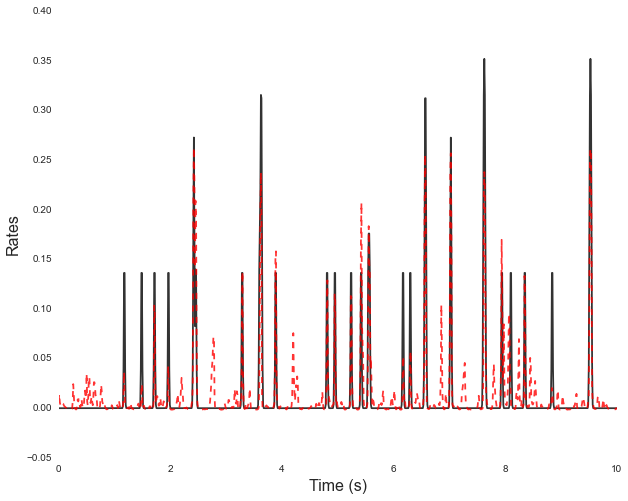

In [42]:
subset = 1000
times = np.linspace(0, 0.01*len(ln_prediction[:subset]), len(ln_prediction[:subset]))
plot(times, y[:len(ln_prediction[:subset]), 0], 'k', alpha=0.8)
plot(times, ln_prediction[:subset], 'r--', alpha=0.8)
xlabel('Time (s)', fontsize=16)
ylabel('Rates', fontsize=16)

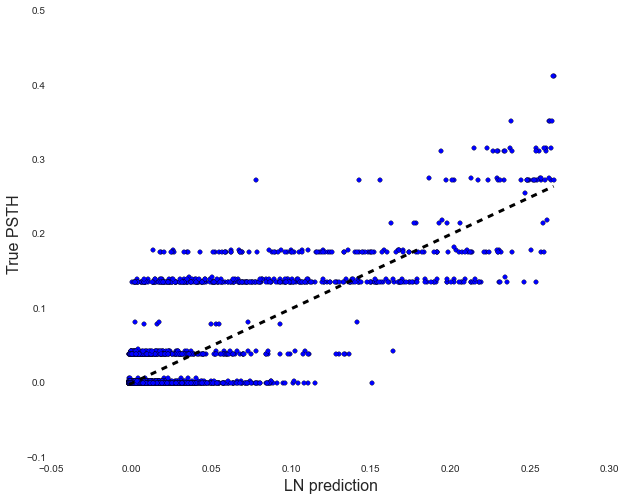

In [35]:
#xs = np.linspace(np.min([ln_prediction, y[:len(ln_prediction),0]]),np.max([ln_prediction, y[:len(ln_prediction),0]]),100)
xs = np.linspace(np.min(ln_prediction), np.max(ln_prediction), 100)
scatter(ln_prediction, y[:len(ln_prediction),0])
plot(xs,xs,'k--', linewidth=3)
xlabel('LN prediction', fontsize=16)
ylabel('True PSTH', fontsize=16)

# What is the overall correlation coefficient?

In [40]:
ln_corrcoef, alpha = pearsonr(ln_prediction, y[:len(ln_prediction), 0])
print 'The correlation coefficient between true rates and best LN model is %f.' %(ln_corrcoef)

The correlation coefficient between true rates and best LN model is 0.824668.


# How does the LN model perform on held-out data?

In [157]:
data_amounts = [6000, 18000, 30000, 60000]
train_acc_history = {}
val_acc_history   = {}

for train in data_amounts:
    #train = 20000
    test  = 10000

    X_subset = X[:train+test]
    y_subset = y[:train+test, 0]

    drawIndices = np.random.choice(X_subset.shape[0], size=X_subset.shape[0], replace=False)
    trainMask = drawIndices[:train]
    testMask  = drawIndices[train:]

    X_train = X_subset[trainMask]
    X_test  = X_subset[testMask]

    # move labels into same space as X
    y_train = y_subset[trainMask]
    y_test  = y_subset[testMask]

    # Zero-mean the data
    #mean_pixel = np.mean(X_train, dtype='float32')

    # surprisingly, the following doesn't do anything!
    #X_train   -= mean_pixel
    #X_test    -= mean_pixel

    # Fit linear filter to training data
    X_sta_train      = sta(X_train, y_train)
    X_sta_train_mean = np.mean(X_sta_train)
    X_sta_train     -= X_sta_train_mean

    # Generate linear predictions
    l_pred_train  = np.tensordot(X_train, X_sta_train, axes=3)
    l_pred_test   = np.tensordot(X_test, X_sta_train, axes=3)

    # Fit logistic nonlinearity to training data
    popt, pcov = curve_fit(logistic, l_pred_train, y_train)

    # Generate nonlinear predictions from nonlinearity trained on (X_train, y_train)
    ln_pred_train = logistic(l_pred_train, *popt)
    ln_pred_test  = logistic(l_pred_test, *popt)

    ln_corrcoef_train, alpha = pearsonr(ln_pred_train, y_train)
    ln_corrcoef_test, alpha  = pearsonr(ln_pred_test,  y_test)
    print 'Corr Coeff between LN model and true PSTH: train: %f, test: %f.' %(ln_corrcoef_train, ln_corrcoef_test)
    
    train_acc_history[train] = ln_corrcoef_train
    val_acc_history[train] = ln_corrcoef_test

0
Corr Coeff between LN model and true PSTH: train: 0.976674, test: 0.049726.
0
Corr Coeff between LN model and true PSTH: train: 0.950968, test: 0.078527.
0
Corr Coeff between LN model and true PSTH: train: 0.934584, test: 0.066739.
0
Corr Coeff between LN model and true PSTH: train: 0.894963, test: 0.121400.


In [ ]:
data_amounts = [90000, 120000, 180000]
#train_acc_history = {}
#val_acc_history   = {}
batchSize = 10000

for train in data_amounts:
    #train = 20000
    test  = 10000

    X_subset = X[:train+test]
    y_subset = y[:train+test, 0]

    drawIndices = np.random.choice(X_subset.shape[0], size=X_subset.shape[0], replace=False)
    trainMask = drawIndices[:train]
    testMask  = drawIndices[train:]

    X_train = X_subset[trainMask]
    X_test  = X_subset[testMask]

    # move labels into same space as X
    y_train = y_subset[trainMask]
    y_test  = y_subset[testMask]

    # Zero-mean the data
    #mean_pixel = np.mean(X_train, dtype='float32')

    # surprisingly, the following doesn't do anything!
    #X_train   -= mean_pixel
    #X_test    -= mean_pixel

    # Fit linear filter to training data
    X_sta_train      = sta(X_train, y_train)
    X_sta_train_mean = np.mean(X_sta_train)
    X_sta_train     -= X_sta_train_mean

    # Generate linear predictions
    l_pred_train = np.zeros(y_train.shape)
    l_pred_test  = np.zeros(y_test.shape)
    for it in xrange(y_train.shape[0] / batchSize):
        l_pred_train[it*batchSize:(it+1)*batchSize] = np.tensordot(X_train[it*batchSize:(it+1)*batchSize], X_sta_train, axes=3)
    for it in xrange(y_test.shape[0] / batchSize):
        l_pred_test[it*batchSize:(it+1)*batchSize]  = np.tensordot(X_test[it*batchSize:(it+1)*batchSize], X_sta_train, axes=3)

    # Fit logistic nonlinearity to training data
    popt, pcov = curve_fit(logistic, l_pred_train, y_train)

    # Generate nonlinear predictions from nonlinearity trained on (X_train, y_train)
    ln_pred_train = np.zeros(y_train.shape)
    ln_pred_test  = np.zeros(y_test.shape)
    for it in xrange(y_train.shape[0] / batchSize):
        ln_pred_train[it*batchSize:(it+1)*batchSize] = logistic(l_pred_train[it*batchSize:(it+1)*batchSize], *popt)
    for it in xrange(y_test.shape[0] / batchSize):
        ln_pred_test[it*batchSize:(it+1)*batchSize]  = logistic(l_pred_test[it*batchSize:(it+1)*batchSize], *popt)

    ln_corrcoef_train, alpha = pearsonr(ln_pred_train, y_train)
    ln_corrcoef_test, alpha  = pearsonr(ln_pred_test,  y_test)
    print 'Corr Coeff between LN model and true PSTH: train: %f, test: %f.' %(ln_corrcoef_train, ln_corrcoef_test)
    
    train_acc_history[train] = ln_corrcoef_train
    val_acc_history[train] = ln_corrcoef_test

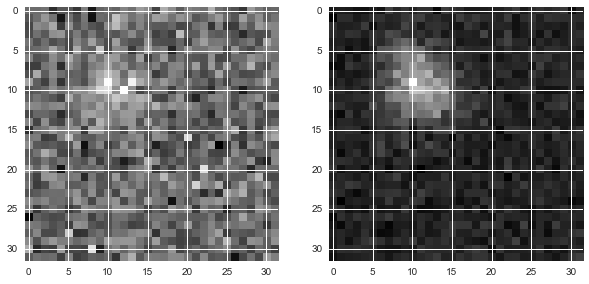

In [68]:
fig = gcf()
fig.set_size_inches((10,5))

subplot(1,2,1)
imshow(X_sta_train[30])
subplot(1,2,2)
imshow(X_sta[30])

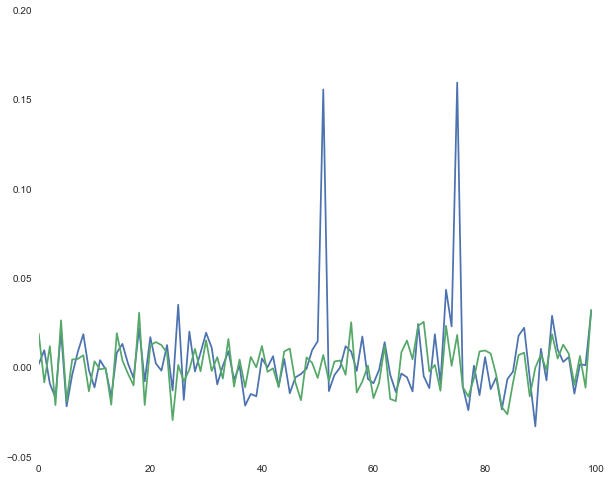

In [136]:
plot(np.tensordot(X_test, X_sta_test-np.mean(X_sta_test), axes=3)[:100])
plot(np.tensordot(X_test, X_sta_train-np.mean(X_sta_train), axes=3)[:100])

# Train a 2 layer convnet

In [19]:
from utils.classifiers.convnet import init_two_layer_convnet
from utils.classifiers.convnet import two_layer_convnet

In [20]:
model = init_two_layer_convnet(input_shape=X[0].shape, num_classes=1, filter_size=11, 
                               num_filters=8, weight_scale=0.01)

### Work on subset of the total data

In [12]:
subset = 5000
cell   = 0
X_subset = X[:subset]
y_subset = y[:subset, cell]

In [13]:
# Divide examples into training, validation, and test sets
numVal   = 500
numTest  = 500
numTrain = X_subset.shape[0] - numVal - numTest
drawIndices = np.random.choice(X_subset.shape[0], size=X_subset.shape[0], replace=False)
trainMask = drawIndices[:numTrain]
valMask   = drawIndices[numTrain:-numTest]
testMask  = drawIndices[numTrain + numVal:]

X_train = X_subset[trainMask]
X_val   = X_subset[valMask]
X_test  = X_subset[testMask]

# move labels into same space as X
y_train = y_subset[trainMask]
y_val   = y_subset[valMask]
y_test  = y_subset[testMask]

# Zero-mean the data
mean_img = np.mean(X_train, axis=0, dtype=str(X_train.dtype))
X_train -= mean_img
X_val -= mean_img
X_test -= mean_img

In [14]:
X_train.shape

(4000, 40, 50, 50)

In [15]:
y_train.shape

(4000,)

In [16]:
y_val.shape

(500,)

In [17]:
y_test.shape

(500,)

In [21]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 1e-3
reg = 0.001 #0.001
dropout = 1.0
num_epochs = 1

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-5,-1,10):
#learning_rate = lr_hist.keys()[np.argmin(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#reg_hist = {} # for r in logspace(-5,-1,10)
#reg = reg_hist.keys()[np.argmin(reg_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


best_model = None
best_val_acc = 0.0 # np.inf

#for reg in logspace(-5,-1,10):
#for learning_rate in logspace(-4,-1,10):
finetuned_model, loss_history, train_acc_history, val_acc_history = trainer.train(X_train, y_train, X_val, y_val,
                                                                                  model, two_layer_convnet,
                                                                                  learning_rate=learning_rate, 
                                                                                  reg=reg, update='rmsprop',
                                                                                  dropout=dropout, 
                                                                                  num_epochs=num_epochs, 
                                                                                  batch_size=50, verbose=True,
                                                                                 acc_frequency=None)
#print 'Validation error %s for learning rate %s.' %(np.max(val_err_history), learning_rate)
#print 'Validation error %s for regularization %s.' %(np.min(val_err_history), reg)

if np.max(val_acc_history) > best_val_acc:
    best_model = finetuned_model
    best_val_acc = np.max(val_acc_history)

#lr_hist[learning_rate] = np.min(val_err_history)
#reg_hist[reg] = np.min(val_err_history)

starting iteration  0
Finished epoch 0 / 1: cost 0.571045, train: 0.000882, val -0.000071, lr 1.000000e-03
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
Finished epoch 1 / 1: cost 13.103029, train: -0.005197, val -0.027304, lr 9.500000e-04
finished optimization. best validation accuracy: 0.000000


In [22]:
model['W1'].shape

(8, 40, 11, 11)

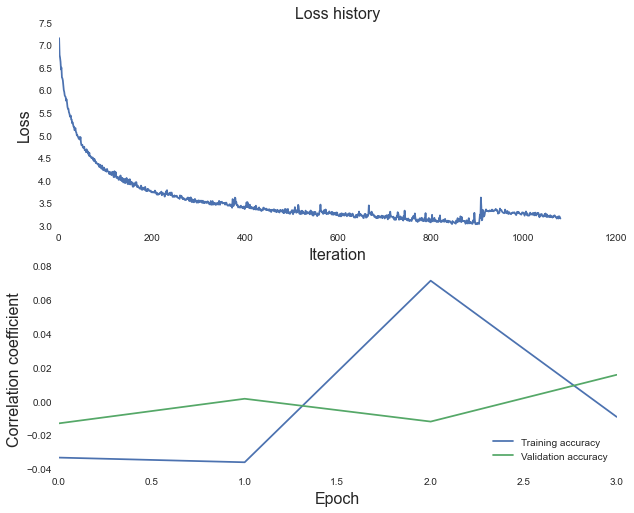

In [236]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#yscale('log')

ax2 = plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)

In [237]:
def fitTotalLNModel(inputData, modelOutput):
    modelOutput = modelOutput.reshape((len(modelOutput), 1, 1, 1))
    sta = inputData * modelOutput
    return np.sum(sta, axis=0)

In [ ]:
probs = two_layer_convnet(X_train[:100], finetuned_model)

In [ ]:
modelSTA = fitTotalLNModel(X_train[:100], probs)

In [ ]:
imshow(modelSTA[3,:,:])
title('LN fit to total CNN', fontsize=16)